In [1]:
from IPython.display import HTML
css_str = '<style> \
.jp-Button path { fill: #616161;} \
text.terms { fill: #616161;} \
</style>'
display(HTML(css_str ))

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)
%config Completer.use_jedi = False
import pathlib
import os

In [3]:
import spacy
import scispacy
from spacy import displacy

In [4]:
from spacy.lang.en.stop_words import STOP_WORDS

In [5]:
len(STOP_WORDS)

326

In [6]:
import pandas as pd
import tqdm
import json
import re
from plotnine import *

In [7]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [8]:
gensim.__version__

'3.8.3'

In [13]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

In [14]:
pyLDAvis.__version__

'3.3.1'

In [15]:
%pwd
%cd "C:/zhijuncao/R/textming/cardioprot/"
%pwd


C:\zhijuncao\R\textming\cardioprot


'C:\\zhijuncao\\R\\textming\\cardioprot'

In [16]:
s ="aa<i>fee<i/>fdd hellofdf<b>yes<b/>wi&gtl&ltfordii</i>."
def remove_tags(s):
    #
    s1 = re.sub("<i>|</i>|<b>|</b>|<sup>|</sup>|<sub>|</sub>|=|â€‰|&[gl]t|â‰¥|\xa0|Â|\(|\)|↵ ‡", "", s)
    return s1

In [17]:
#doc = pd.read_excel ("C:/zhijuncao/R/textming/metabolomics_protomics_toxicity.xlsx")
#doc = pd.read_csv("C:/zhijuncao/R/textming/protomicscovid19.csv")
doc = pd.read_excel ("C:/zhijuncao/R/textming/cardioprot/cardioprot_abstract.xlsx")
print(doc.shape)
doc.dropna(subset=["Abstract"], inplace=True)
doc.reset_index(drop=True, inplace=True)
print(doc.shape)
doc.head(2)

(41, 10)
(41, 10)


,Unnamed: 0,pmid,Title,Abstract,Keywords,Journal,Authors,Affiliations,ArticleIds,LatestDate
0,0,33536059,Plasma proteome profiling of cardiotoxicity in...,Cardiovascular toxicity is a notorious complic...,Cardiac toxicity Doxorubicin Lymphoma Proteomics,"Cardio-oncology (London, England)",Charlott Mörth\n Amal Abu Sabaa\n Eva Freyhult...,"Department of Immunology, Genetics & Pathology...",33536059_10.1186/s40959-021-00092-0_10.1186/s4...,2021-02-05 06:01:00
1,1,33395532,Functionally Integrated Top-Down Proteomics fo...,Three-dimensional (3D) human induced pluripote...,cardiac function engineered cardiac tissue hum...,Journal of proteome research,Jake A Melby\n Willem J de Lange\n Jianhua Zha...,"Department of Chemistry, University of Wiscons...",33395532_10.1021/acs.jproteome.0c00830_PMC7872...,2021-01-04 20:04:00


In [18]:
abstract = doc["Abstract"]
#abstract = doc["abstract"]
abstract_clean = [remove_tags(i) for i in abstract]

In [19]:
nlp_sci = spacy.load("en_core_sci_lg")

In [20]:
def nlp_process(doc, model):
    doc_nlp = []
# Iterates through each article in the corpus.
    for d in tqdm.tqdm(doc):
    # Passes that article through the pipeline and adds to a new list.
        pr = model(d)
        doc_nlp.append(pr)
    return doc_nlp

In [21]:
sci = nlp_process(abstract_clean[:], nlp_sci)

100%|██████████| 41/41 [00:02<00:00, 17.75it/s]


In [22]:
for i in range(len(sci)):
    sci[i].user_data["title"] c= f"pmid: {doc.pmid[i]}, title: {doc.Title[i]}, model: sci"

In [23]:
displacy.render(sci[1], style='ent')

In [24]:
sci_lemm_temp = [[ent.lemma_ for ent in doc if len(ent.lemma_)>2 and (ent.lemma_ not in STOP_WORDS)] for doc in sci]

In [103]:
sci_lemm_temp = [[re.sub(' ', '_',  ent.lemma_) for ent in doc.ents if len(ent.lemma_)>2 and (ent.lemma_ not in STOP_WORDS)] for doc in sci]

In [26]:
def filter_term_fre(docs, k):
    doc_filtered =[]
    for doc in docs:
        term_fre = {term: doc.count(term) for term in set(doc)}
        terms = [term for term in term_fre if term_fre[term]>k]
        terms_k = [term for term in doc if term in terms]
        doc_filtered.append(terms_k)
    return doc_filtered

In [27]:
%%time
sci_lemm = filter_term_fre(sci_lemm_temp,0)

Wall time: 9 ms


In [28]:
len(sci_lemm)

41

In [29]:
%%time
# Creates, which is a mapping of word IDs to words.,
id2word = corpora.Dictionary(sci_lemm)
print(id2word)
id2word.filter_extremes(no_below=2, no_above=1)
print(id2word)
# Turns each document into a bag of words.
corpus = [id2word.doc2bow(doc) for doc in sci_lemm]

Dictionary(1574 unique tokens: ['allow', 'analysis', 'arise', 'assay', 'associate']...)
Dictionary(534 unique tokens: ['allow', 'analysis', 'assay', 'associate', 'biological']...)
Wall time: 9.03 ms


## Mallet

In [32]:
os.environ.update({'MALLET_HOME': r'C:/zhijuncao/py/mallet-2.0.8/'})
mallet_path =  r'C:/zhijuncao/py/mallet-2.0.8/bin/mallet' 
mallet_path

'C:/zhijuncao/py/mallet-2.0.8/bin/mallet'

In [3]:
num_topics =list(range(5, 30, 5))

In [33]:
%%time
models = []
coherence = []
perplexity = []
for k in tqdm.tqdm(num_topics):
    mallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=k, id2word=id2word)
    mallet2lda = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(mallet)
    models.append(mallet2lda)
    
    coherence.append(CoherenceModel(model=mallet2lda, texts=sci_lemm, dictionary=id2word, coherence='c_v').get_coherence())


100%|██████████| 5/5 [03:06<00:00, 37.23s/it]

Wall time: 3min 6s


In [34]:
import plotnine as pn

   topics  coherence
0       5   0.430191
1      10   0.438551
2      15   0.456495
3      20   0.445394
4      25   0.436788


C:\Users\ZCao\AppData\Roaming\Python\Python38\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 5 x 3 in image.
C:\Users\ZCao\AppData\Roaming\Python\Python38\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/zhijuncao/R/textming/cardioprot/cardioprot_doc_topic_number_optimization.pdf


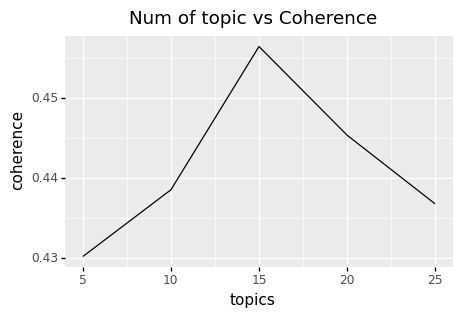

<ggplot: (169022257978)>

In [35]:
eval_para = pd.DataFrame({"topics": num_topics, "coherence":coherence})
print(eval_para)
opti_topic = (pn.ggplot(eval_para, pn.aes('topics', 'coherence'))+ pn.geom_line()+ pn.labels.ggtitle("Num of topic vs Coherence"))
pn.options.figure_size = (5, 3)
opti_topic.save('C:/zhijuncao/R/textming/cardioprot/cardioprot_doc_topic_number_optimization.pdf')
opti_topic

In [36]:
def doc_topic_table(ldamodel=mallet2lda, corpus=corpus):
    sent_topics_df = pd.DataFrame()
    for i, row in tqdm.tqdm(enumerate(ldamodel[corpus])):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([i, round(prop_topic,4), int(topic_num),  topic_keywords]), ignore_index=True)
        
    sent_topics_df.columns = ['DocID','Perc_Contribution','Topic',  'Topic_Keywords']

    #contents = pd.Series(texts)
    
    sent_topics_df['Topic'] = sent_topics_df['Topic'] +1
   
    
    return(sent_topics_df)

In [37]:
DocID =doc.loc[:, ['pmid','Title']]
DocID['DocID'] = list(range(len(DocID['pmid'])))
sent_topics_df= doc_topic_table(ldamodel=models[2], corpus=corpus)
doc_topics_result = DocID.merge(sent_topics_df, on='DocID', how='right')
doc_topics_result_sorted = doc_topics_result.sort_values(by=['Topic', 'Perc_Contribution'], ascending=[True, False])
doc_topics_result_sorted = doc_topics_result_sorted.astype({'Topic':'int64'})


41it [00:01, 25.72it/s]


In [38]:
doc_topics_result_sorted.sort_values(by=['Perc_Contribution']).groupby('DocID').apply(lambda x: x.nlargest(2, 'Perc_Contribution')).to_excel('C:/zhijuncao/R/textming/cardioprot/cardioprot_doc_dominant2_topic15.xlsx')

In [39]:
doc_topics_result_sorted.to_excel('C:/zhijuncao/R/textming/cardioprot/cardioprot_doc_topic15.xlsx')

In [40]:
doc_topics_result_sorted.head(2)

,pmid,Title,DocID,Perc_Contribution,Topic,Topic_Keywords
90,33110475,Peptidomics Analysis Reveals Peptide PDCryab1 ...,6,0.2784,1,"pathway, function, peptide, effect, process, b..."
421,26462128,Systems biology approaches to adverse drug eff...,28,0.1349,1,"pathway, function, peptide, effect, process, b..."


In [41]:
df_pivot = doc_topics_result_sorted.pivot(columns='Topic',values='Perc_Contribution', index='Title')

In [42]:
df_pivot

Topic,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Title,,,,,,,,,,,,,,,
A BAG3 chaperone complex maintains cardiomyocyte function during proteotoxic stress.,0.0734,0.0796,0.0647,0.0674,0.1063,0.0509,0.0603,0.0345,0.0748,0.0478,0.0645,0.1075,0.0871,0.0288,0.0523
A Review of Toxins from Cnidaria.,0.0494,0.0392,0.1090,0.0352,0.0565,0.1348,0.0333,0.0940,0.0597,0.0488,0.1197,0.0664,0.0403,0.0627,0.0511
Advances in proteomic study of cardiac amyloidosis: progress and potential.,0.0322,0.0320,0.0478,0.1633,0.0924,0.0370,0.1054,0.0534,0.0405,0.0498,0.1051,0.0498,0.0490,0.1017,0.0405
Analysis of protein-protein interactions in MCF-7 and MDA-MB-231 cell lines using phthalic acid chemical probes.,0.0303,0.0325,0.0571,0.0696,0.0390,0.0555,0.0496,0.0495,0.0390,0.0475,0.0557,0.0649,0.2482,0.0305,0.1311
Biomarker Discovery in Cardio-Oncology.,0.0529,0.0529,0.0529,0.0595,0.0543,0.0688,0.0678,0.0529,0.0758,0.0701,0.1005,0.0688,0.0626,0.1073,0.0529
Cardiac phosphoproteome reveals cell signaling events involved in doxorubicin cardiotoxicity.,0.0311,0.1346,0.0474,0.0611,0.1473,0.0549,0.0437,0.0297,0.0380,0.0948,0.0592,0.0783,0.0976,0.0375,0.0449
Chemical proteomics-based analysis of off-target binding profiles for rosiglitazone and pioglitazone: clues for assessing potential for cardiotoxicity.,0.0556,0.0639,0.0855,0.0435,0.1062,0.0775,0.0429,0.0330,0.0708,0.0590,0.0580,0.1166,0.0756,0.0655,0.0463
Comparative proteomic analysis reveals heart toxicity induced by chronic arsenic exposure in rats.,0.0733,0.0346,0.0547,0.0670,0.1236,0.0532,0.0893,0.0641,0.0611,0.1583,0.0350,0.0350,0.0588,0.0562,0.0358
"Early Diagnosis and Prediction of Anticancer Drug-induced Cardiotoxicity: From Cardiac Imaging to ""Omics"" Technologies.",0.0384,0.0383,0.0498,0.0505,0.0644,0.0664,0.0387,0.0728,0.0821,0.0520,0.0653,0.0921,0.0383,0.2011,0.0498


In [518]:
import numpy as np

In [43]:
pn.options.figure_size = (6.4, 6.8)
plot = (pn.ggplot(doc_topics_result_sorted.query('Perc_Contribution>0'), pn.aes('factor(Topic)', 'factor(Title)' ))+ pn.geom_point(aes(size='Perc_Contribution')))
plot.save('C:/zhijuncao/R/textming/cardioprot/cardioprot_doc_topic15_dotplot.pdf')

C:\Users\ZCao\AppData\Roaming\Python\Python38\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 6.4 x 6.8 in image.
C:\Users\ZCao\AppData\Roaming\Python\Python38\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/zhijuncao/R/textming/cardioprot/cardioprot_doc_topic15_dotplot.pdf


In [44]:
import seaborn as sns
sns.set_theme(color_codes=False)
import matplotlib.pyplot as plt

C:\Users\ZCao\AppData\Roaming\Python\Python38\site-packages\seaborn\matrix.py:1205: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


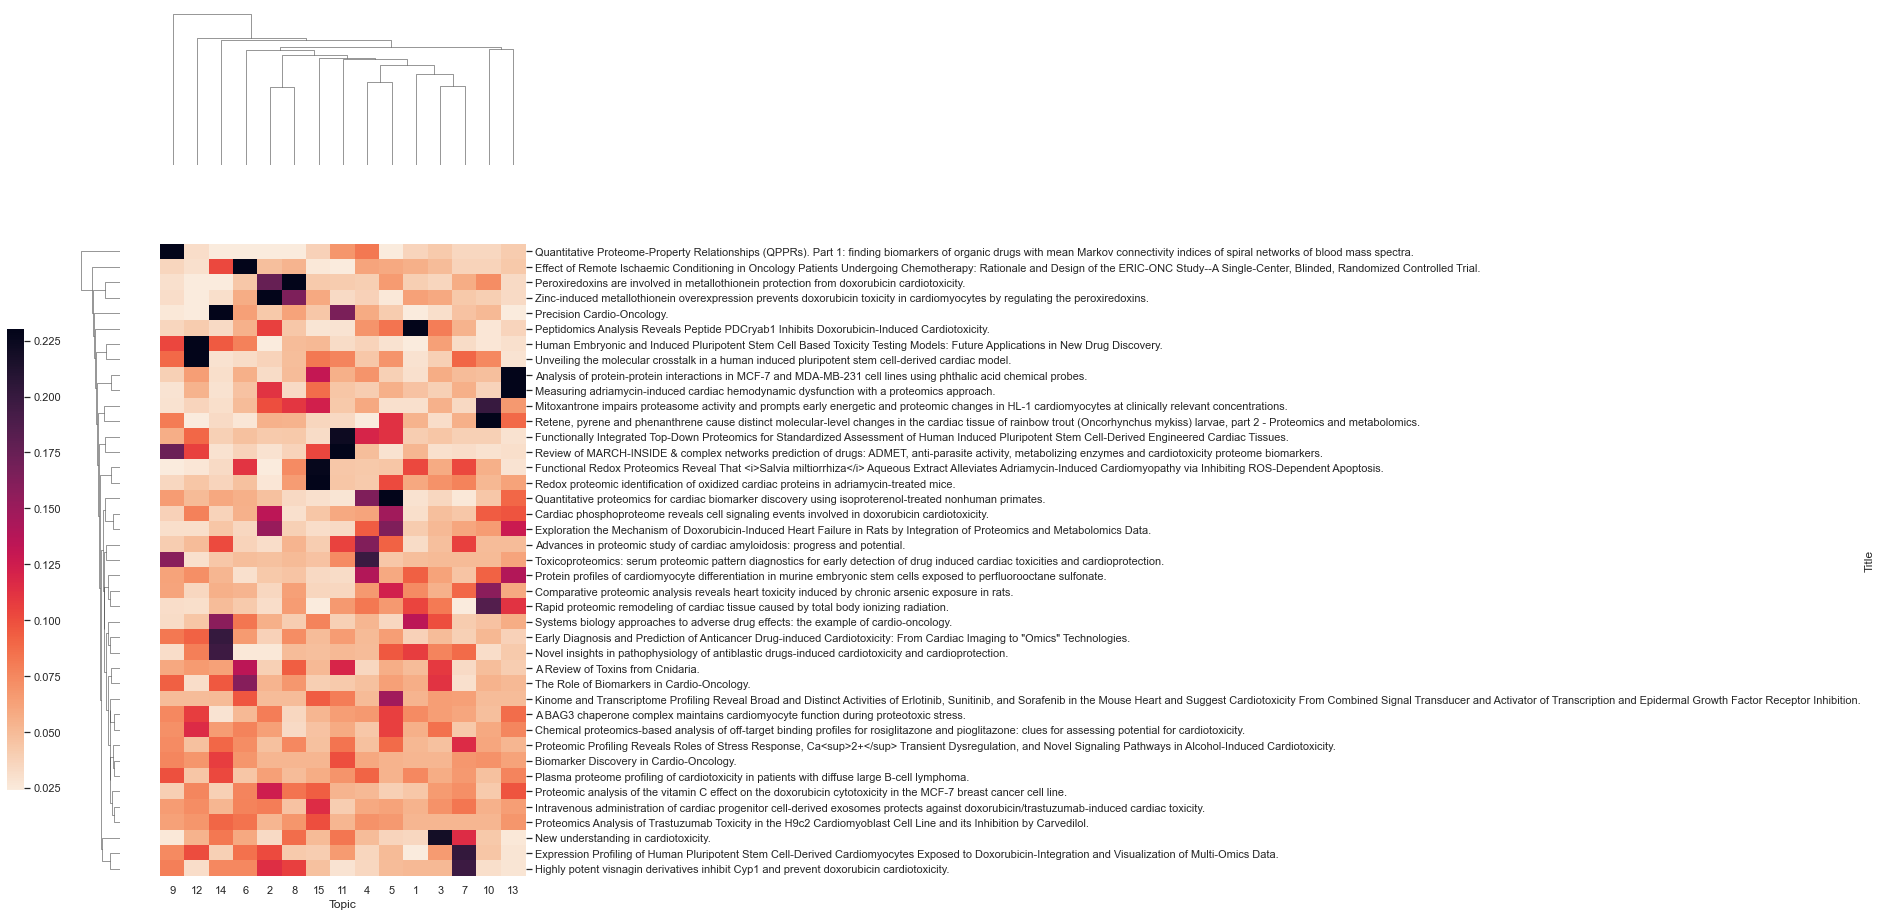

In [52]:
g = sns.clustermap(df_pivot.fillna(0.000001),
                   figsize=(8, 16),
                   row_cluster=True,
                   robust = True,
                   mask=df_pivot.isna(),
                   cmap = 'rocket_r',
                   dendrogram_ratio=(.1, .2),
                   cbar_pos=(0, .2, .03, .4))

In [53]:
g.savefig('C:/zhijuncao/R/textming/cardioprot/cardioprot_doc_topic15_heatmap.pdf', dpi=1200)

In [ ]:
dominat_sorted

In [68]:
vismallet = gensimvis.prepare(models[2], corpus, dictionary=id2word,  sort_topics=False)

In [50]:
pyLDAvis.save_html(vismallet, "C:/zhijuncao/R/textming/cardioprot/cardioprot_doc_topic15.html")

In [67]:
vismallet

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.102981 -0.227558       1        1  10.011246
1     -0.082145  0.267866       2        1   9.631675
2     -0.138971 -0.226806       3        1  10.636608
3     -0.158375 -0.001789       4        1  10.588994
4      0.183376  0.030267       5        1   9.054370
5      0.174619  0.095920       6        1   9.675273
6     -0.188632  0.147808       7        1  10.010022
7     -0.093368  0.101438       8        1   9.991881
8      0.298945  0.010155       9        1   9.992872
9      0.107532 -0.197302      10        1  10.407058, topic_info=               Term       Freq      Total Category  logprob  loglift
15          protein  82.000000  82.000000  Default  30.0000  30.0000
27   cardiotoxicity  64.000000  64.000000  Default  29.0000  29.0000
26          cardiac  48.000000  48.000000  Default  28.0000  28.0000
62        proteomic  43.000000  43.000000  Default  27.0000  27.0000
102           heart  37.000000  37.000000  Default  26.0000  26.0000
..              ...        ...        ...      ...      ...      ...
208         involve   9.577554  18.851162  Topic10  -3.5264   1.5855
249  dose-dependent   4.256691   5.302433  Topic10  -4.3373   2.0430
153    cytotoxicity   4.256691   5.311411  Topic10  -4.3373   2.0413
120         pathway   7.449209  21.160570  Topic10  -3.7777   1.2187
27   cardiotoxicity  10.641727  64.076863  Topic10  -3.4210   0.4674

[411 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
368       5  0.931837       -omic
526       2  0.922438      Markov
75        4  0.999005    abnormal
140       7  0.961006      accord
76        3  0.970496        acid
...     ...       ...         ...
268       8  0.956353       vitro
22        2  0.922438  well-known
230       4  0.999005  widespread
367       2  0.922438        work
139       4  0.999005       worth

[416 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])